# This notebook does IA modeling.

Notebook by: Jonathan Blazek (blazek@berkeley.edu)  
FAST-PT on github: https://github.com/JoeMcEwen/FAST-PT  
Easy ccl installation in a conda environment: `conda install -c conda-forge pyccl`  
Easy fast-pt installation: `pip install fast-pt`  
(Note, use `--no-deps` if you use `conda` for most python packages)

In [1]:
# import standard packages
import numpy as np
import pylab as plt
%matplotlib inline
from scipy.interpolate import interp1d

# import fastpt
import fastpt as fpt
import fastpt.HT as HT

# import the Core Cosmology Library (CCL) if you have it
try:
    import pyccl as ccl
    import pyccl.ccllib as lib
    import pyccl.nl_pt as pt
    have_ccl = True
except:
    have_ccl = False
    print('CCL not found. Steps with CCL will be skipped.')

# If you want to test HT against external Bessel transform code, e.g. mcfit
try:
    from mcfit import P2xi
    have_mcfit = True
except:
    have_mcfit = False
    print('mcfit not found. Steps with mcfit will be skipped.')

<h3> Get $P_{\rm lin}(k)$ and $P_{\rm nl}(k)$: </h3>

In [2]:
## Get from CCL (which runs CLASS by default)
if have_ccl:
    # set a cosmology
    Omega_c=0.27
    Omega_b=0.045
    cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
    h=0.67
    Omega_m=Omega_c+Omega_b
    Omega_m_0=Omega_m

    # Get the linear power spectrum at z=0 for our given cosmologies
    # k array to be used for power spectra
    nk = 512
    log10kmin = -5
    log10kmax = 2
    ks = np.logspace(log10kmin,log10kmax,nk)
    k = ks/h # convert to h/Mpc
    
    # at individual power spectra
    pk_lin_z0 = h**3*ccl.linear_matter_power(cosmo,ks,1)
    pk_lin_z1 = h**3*ccl.linear_matter_power(cosmo,ks,0.5)
    pk_nl_z0 = h**3*ccl.nonlin_matter_power(cosmo,ks,1)
    pk_nl_z1 = h**3*ccl.nonlin_matter_power(cosmo,ks,0.5)
    
    
    # interpolation Pk
    z = np.linspace(0, 1.5, 1024)
    gz = ccl.growth_factor(cosmo, 1./(1+z))
    sf = (1./(1+z))[::-1]
    # Note this has been converted to Mpc/h units
    lpk_array = np.log(np.array([h**3*ccl.linear_matter_power(cosmo,ks,a) for a in sf]))
    pk_lin = ccl.Pk2D(a_arr=sf, lk_arr=np.log(k), pk_arr=lpk_array, is_logp=True)
    lpk_array = np.log(np.array([h**3*ccl.nonlin_matter_power(cosmo,ks,a) for a in sf]))
    pk_nl = ccl.Pk2D(a_arr=sf, lk_arr=np.log(k), pk_arr=lpk_array, is_logp=True)

## Or get from pre-computed CAMB run
# This file is in the same examples/ folder
d = np.loadtxt('Pk_test.dat')
k_CAMB = d[:, 0]
pk_CAMB = d[:, 1]
p22 = d[:, 2]
p13 = d[:, 3]

if not have_ccl:
    ks = k
    pk_lin_z0 = pk
    
## Or get from your preferred Boltzmann code

# Note: k needs to be evenly log spaced. FAST-PT will raise an error if it's not.

# Note: CCL outputs in units of Mpc not Mpc/h

In [3]:
# Galaxy biases
b_1 = 2.0 # constant values for now. But can also be z-dependent
b_2 = 1.0
b_s = 1.0

# Biases for IAs. Will be converted to the input c_IA values below.
a_1 = 1.
a_2 = 0.5
a_d = 0.5

# Let's convert the a_IA values into the correctly normalized c_IA values:
# First, do it explicitly:
Om_m = cosmo['Omega_m']
rho_crit = lib.cvar.constants.RHO_CRITICAL
rho_m = lib.cvar.constants.RHO_CRITICAL * cosmo['Omega_m']
Om_m_fid = 0.3 #or could use DES convention and just remove Om_m/Om_m_fid

c_1_t = -1*a_1*5e-14*rho_crit*cosmo['Omega_m']/gz
c_d_t = -1*a_d*5e-14*rho_crit*cosmo['Omega_m']/gz
c_2_t = a_2*5*5e-14*rho_crit*cosmo['Omega_m']**2/(Om_m_fid*gz**2) #Blazek2019 convention
c_2_t = a_2*5*5e-14*rho_crit*cosmo['Omega_m']/(gz**2) #DES convention

# Or we just use the built-in function for IA normalization:
c_1,c_d,c_2 = pt.translate_IA_norm(cosmo, z, a1=a_1, a1delta=a_d, a2=a_2, Om_m2_for_c2 = False)

In [4]:
# Set FAST-PT settings.

# the to_do list sets the k-grid quantities needed in initialization (e.g. the relevant gamma functions)
to_do = ['one_loop_dd', 'dd_bias', 'IA_all']

pad_factor = 1 # padding the edges with zeros before Pk repeats
n_pad = pad_factor*len(ks)
low_extrap = -5 # Extend Plin to this log10 value if necessary (power law)
high_extrap = 3 # Extend Plin to this log10 value if necessary (power law)
P_window = None # Smooth the input power spectrum edges (typically not needed, especially with zero padding)
C_window = .75 # Smooth the Fourier coefficients of Plin to remove high-frequency noise.

<h3> Initialize a FAST-PT object on a given k-grid. </h3>
<h3> This step does not depend on cosmology and can be re-used, e.g. in an MCMC. </h3>

In [5]:
# FAST-PT will parse the full to-do list and only calculate each needed quantity once.
# Ideally, the initialization happens once per likelihood evaluation, or even once per chain.

fpt_obj = fpt.FASTPT(ks,to_do=to_do,low_extrap=low_extrap,high_extrap=high_extrap,n_pad=n_pad)

<h3> Or we can use built-in CCL functionality for FAST-PT. This uses PTTracer objects and PTCalculator.</h3>

In [6]:
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-4, log10k_max=2, nk_per_decade=20)

# Number counts (galaxy clustering)
ptt_g = pt.PTNumberCountsTracer(b1=b_1, b2=b_2, bs=b_s)

# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1), c2=(z,c_2), cdelta=(z,c_d)) # full TATT model
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1)) # NLA model

# Matter
ptt_m = pt.PTMatterTracer()

# Note that we've assumed constant biases for simplicity, but you can also make them z-dependent:
bz = b_1 / gz
ptt_g_b = pt.PTNumberCountsTracer(b1=(z, bz))

In [7]:
# Calculate some power spectra with FAST-PT

# Galaxies x galaxies.
# If `tracer2` is missing, an auto-correlation for the first tracer is assumed.
pk_gg = pt.get_pt_pk2d(cosmo, ptt_g, ptc=ptc)

# Galaxies x matter
pk_gm = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_m, ptc=ptc)

# Galaxies x IAs
pk_gi_tatt = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_i, ptc=ptc)
pk_gi_nla = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_i_nla, ptc=ptc)

# IAs x IAs
pk_ii, pk_ii_bb = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_i, ptc=ptc, return_ia_ee_and_bb=True)
pk_ii_nla = pt.get_pt_pk2d(cosmo, ptt_i_nla, tracer2=ptt_i_nla, ptc=ptc)

# IAs x matter
pk_im = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_m, ptc=ptc)

# Matter x matter
pk_mm = pt.get_pt_pk2d(cosmo, ptt_m, tracer2=ptt_m, ptc=ptc)

<h3> Evaluate the NLA model. </h3>

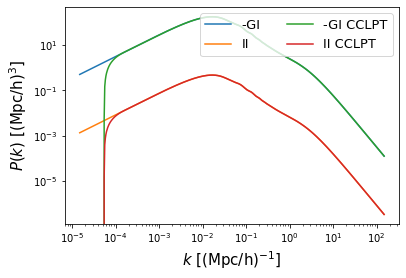

In [8]:
# set the redshift for calculations.
zz=0.375 # this is currently the mean redshift of our particular redmagic sample.

# These are the NLA model power spectra calculated by hand:
c_1_zz,c_d_zz,c_2_zz = pt.translate_IA_norm(cosmo, zz, a1=a_1, a1delta=a_d, a2=a_2, Om_m2_for_c2 = False)
pk_nl0=pk_nl.eval(k,1./(1+zz),cosmo)
pk_lin0=pk_lin.eval(k,1./(1+zz),cosmo)
p_GI_zz = c_1_zz*pk_nl0
p_II_zz = c_1_zz**2*pk_nl0
p_gI_zz = b_1*p_GI_zz
p_gI_zz_lin = b_1*c_1_zz*pk_lin0

# This is the NLA model, from CCL:
# need to be careful with factors of h in both k and Pk.
# All internal CCL calculations use Mpc instead of Mpc/h
# So we evaluate at ks and multiply by h**3:
p_gI_ccl = h**3*pk_gi_nla.eval(ks,1./(1+zz),cosmo)
p_II_ccl = h**3*pk_ii_nla.eval(ks,1./(1+zz),cosmo)

#This is the full TATT model, from CCL
p_gI_tatt = h**3*pk_gi_tatt.eval(ks,1./(1+zz),cosmo)

plt.loglog()
plt.plot(k,-1*p_gI_zz,label='-GI')
plt.plot(k,p_II_zz,label='II')
plt.plot(k,-1*p_gI_ccl,label='-GI CCLPT')
plt.plot(k,p_II_ccl,label='II CCLPT')
plt.legend(loc='upper right', ncol=2, fontsize=13)
plt.xlabel(r'$k\,\,[{\rm (Mpc/h)}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm (Mpc/h)^{3}}]$', fontsize=15)
plt.show()

They agree, although there are different extrapolations outside the primary k range.

<h3> FAST-PT includes an implementation of FFTLog for Bessel transforms. </h3>

/Users/blazek/Packages/anaconda3/envs/ccl/lib/python3.6/site-packages/mcfit/mcfit.py:125: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/Users/blazek/Packages/anaconda3/envs/ccl/lib/python3.6/site-packages/mcfit/mcfit.py:219: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


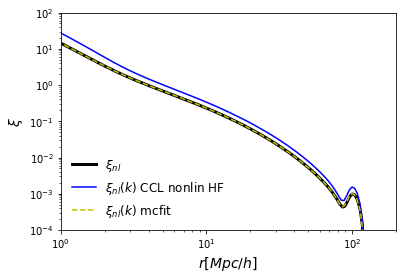

In [9]:
# Calculate the standard correlation function
r,xi = HT.k_to_r(k,pk_nl0,1.5,-1.5,.5, (2.*np.pi)**(-1.5))

if have_mcfit:
    # can test the transform with other code, e.g. mcfit
    rr,xxi = P2xi(k)(pk_nl0)
if have_ccl:
    # can also compare to the output from CCL
    kmin, kmax, nk = 1e-4, 1e1, 128
    rmin, rmax, nr = 1, 2e2, 128
    kccl = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
    rccl = np.logspace(np.log10(rmin), np.log10(rmax), nr)
    a = 1. # Scale factor a z=0
    xi_nl = ccl.correlation_3d(cosmo,a, rccl)

# Make a plot
plt.plot(r,xi, 'k', linewidth=3,label=r'$\xi_{nl}$')
if have_ccl:
    plt.plot(h*rccl,xi_nl, 'b', label=r'$\xi_{nl}(k)$ CCL nonlin HF')
    #remember the factor of h for CCL
if have_mcfit:
    plt.plot(rr ,xxi, 'y--', label=r'$\xi_{nl}(k)$ mcfit')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r [Mpc/h]$', fontsize=14)
plt.ylabel(r'$\xi$', fontsize=14)
plt.xlim(1e0,2e2)
plt.ylim(1e-4,1e2)
plt.legend(loc='lower left', fontsize=12, frameon=False)

<h3> $w_{g+}$ is a $J_2$ transform</h3>

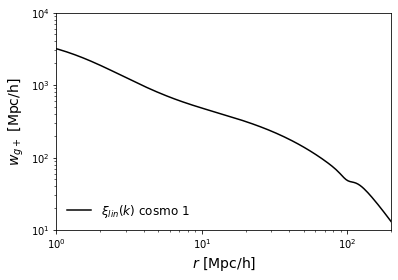

In [10]:
# In the Limber approximation, w_g+ is a simple calculation:

# For the J2 transform (e.g. DeltaSigma or w_g+)
r,xi_2=HT.k_to_r(k,pk_nl0,1.,-1.,2., 4.*np.pi*np.sqrt(np.pi/2.))

# Make a plot
plt.plot(r,xi_2, 'k', label=r'$\xi_{lin}(k)$ cosmo 1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc/h]', fontsize=14)
plt.ylabel(r'$w_{g+}$ [Mpc/h]', fontsize=14)
plt.xlim(1e0,2e2)
plt.ylim(1e1,1e4)
plt.legend(loc='lower left', fontsize=12, frameon=False)

# Now we calculate the properly normalized version

In [11]:
# note the correct pre-factor for w_g+ (see e.g. Blazek2015)
r,wgplus_tatt=HT.k_to_r(k,p_gI_tatt,1.,-1.,2., -1./(2*np.pi))
r,wgplus_nla=HT.k_to_r(k,p_gI_zz,1.,-1.,2., -1./(2*np.pi))
#r,wgplus_nla=HT.k_to_r(k,p_gI_zz,1.,-1.,2., 4.*np.pi*np.sqrt(np.pi/2.))
r,wgplus_nla_ccl=HT.k_to_r(k,p_gI_ccl,1.,-1.,2., -1./(2*np.pi))
r,wgplus_lin=HT.k_to_r(k,p_gI_zz_lin,1.,-1.,2., -1./(2*np.pi))

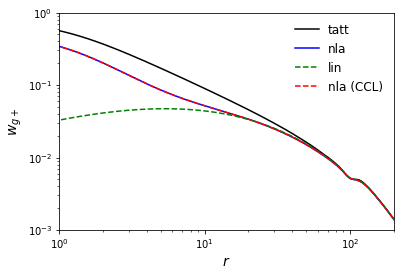

In [12]:
# Make a plot
plt.plot(r,abs(wgplus_tatt), 'k', label=r'tatt')
plt.plot(r,abs(wgplus_nla), 'b', label=r'nla')
plt.plot(r,abs(wgplus_lin), 'g--', label=r'lin')
plt.plot(r,abs(wgplus_nla_ccl), 'r--', label=r'nla (CCL)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$', fontsize=14)
plt.ylabel(r'$w_{g+}$', fontsize=14)
plt.xlim(1e0,2e2)
plt.ylim(1e-3,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

Now we include the NFW profile modeling. We take the density profile, do a j0 transform to get the power spectrum, and then use the standard J2 transform to get the IA signal. This is adapted from old code and will be refactored when possible.

In [13]:
#define some functions which will be needed. These will be moved out of the notebook.

def nfw_r(r,rho_s=1.,r_s=1.):
	"returns the halo density profile in 3d"
	a=r/r_s
	return rho_s/(a*(1.+a)**2)

def rho_bar0(Om_m0=Omega_m_0):
	h = 10**7/(3.086*10**24.)
	G = 6.67*10**-8.
	p = 3.*h*h/(8.*np.pi*G)/(1.99*10**33)*(3.086*10**24.)**3.
	return p*Om_m0
	
def rho_bar0_jab(Om_m0=Omega_m_0):
	h = 1.e5/(3.086e22)
	G = 6.674e-11
	p = 3.*h*h/(8.*np.pi*G)/(1.989e30)*(3.086e22)**3.
	return p*Om_m0

def Rvir(m,delta_vir=337.):
	mev = 10.**m
	return (3.*mev/(4.*delta_vir*np.pi*rho_bar0(Omega_m_0)))**(1./3.)

def A_c(c):
	return np.log(1.+c)-c/(1+c)

def rho_scale(c,z=0.,Om_m0=Omega_m_0,delta_vir=337):
	return rho_bar0(Omega_m_0)*c**3/A_c(c)*delta_vir/3
	#calculated in terms of comoving density, not physical density

def r_scale(M_vir,c,z=0.,Om_m0=Omega_m_0,delta_vir=337):
	return c**(-1)*((3.*M_vir)/(4.*np.pi*delta_vir*rho_bar0(Omega_m_0)))**(1./3)
	#calculated in terms of comoving density, not physical density

r_arr_nfw=np.logspace(-6,5,1000)
#r_arr_nfw = r

In [14]:
# Set some halo parameters
M_halo=10.**12
c_halo=5.*(M_halo/1.e14)**(-0.1)
delta_vir=180
z_obs = zz #this is defined above. Should better connect the z values.
# Check the halo mass
# Check the approximations being made here.
# Update the redshift for the power spectra

In [15]:
# Do calculations of halo profile
rho_s=rho_scale(c_halo,z=z_obs,delta_vir=delta_vir)
r_s=r_scale(M_halo,c_halo,z=z_obs,delta_vir=delta_vir)
R_vir=Rvir(np.log10(M_halo),delta_vir=delta_vir)
nfw_arr=nfw_r(r_arr_nfw,rho_s=rho_s,r_s=r_s)/(rho_bar0())

# Filtered version
sm_scale = 2.0*R_vir
nfw_arr_filt=nfw_arr*np.exp(-1.*(r_arr_nfw/sm_scale)**2)


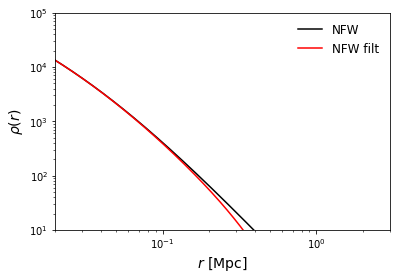

In [16]:
# Make a plot
plt.plot(r_arr_nfw,nfw_arr, 'k', label=r'NFW')
plt.plot(r_arr_nfw,nfw_arr_filt, 'r', label=r'NFW filt')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc]', fontsize=14)
plt.ylabel(r'$\rho(r)$', fontsize=14)
plt.xlim(2e-2,3e0)
plt.ylim(1e1,1e5)
plt.legend(loc='upper right', fontsize=12, frameon=False)

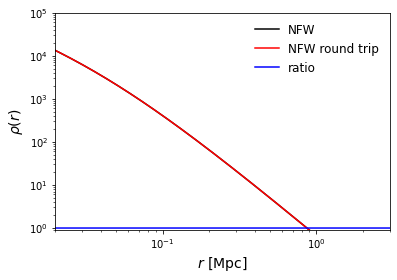

In [17]:
# get the power spectrum
#r,xi = HT.k_to_r(k,pk_nl0,1.5,-1.5,.5, (2.*np.pi)**(-1.5))
k_nfw,P_nfw = HT.r_to_k(r_arr_nfw,nfw_arr,-1.5,1.5,.5, (2.*np.pi)**(1.5))
r_check,xi_check = HT.k_to_r(k_nfw,P_nfw,1.5,-1.5,.5, (2.*np.pi)**(-1.5))

# Make a plot
plt.plot(r_arr_nfw,nfw_arr, 'k', label=r'NFW')
plt.plot(r_check,xi_check, 'r', label=r'NFW round trip')
plt.plot(r_check,nfw_arr/xi_check, 'b', label=r'ratio')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc]', fontsize=14)
plt.ylabel(r'$\rho(r)$', fontsize=14)
plt.xlim(2e-2,3e0)
plt.ylim(0.9e0,1e5)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [18]:
#1 halo contribution:
k_sm=100.
P_IA_nfw = c_1_zz*P_nfw*np.exp(-1.*(k_nfw/k_sm)**2)
r_arr_nfw,wgplus_nfw_arr=HT.k_to_r(k_nfw,P_IA_nfw,1.,-1.,2., -1./(2*np.pi))

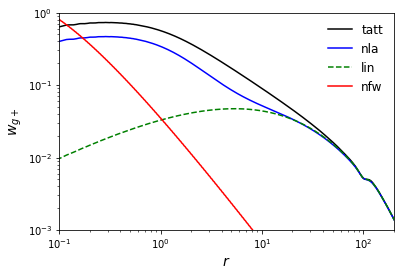

In [19]:
# Make a plot
plt.plot(r,abs(wgplus_tatt), 'k', label=r'tatt')
plt.plot(r,abs(wgplus_nla), 'b', label=r'nla')
plt.plot(r,abs(wgplus_lin), 'g--', label=r'lin')
plt.plot(r_arr_nfw,abs(wgplus_nfw_arr), 'r', label=r'nfw')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$', fontsize=14)
plt.ylabel(r'$w_{g+}$', fontsize=14)
plt.xlim(1e-1,2e2)
plt.ylim(1e-3,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [20]:
#interpolate the nfw contribution to the same r values.
wgplus_nfw_interp=interp1d(r_arr_nfw,wgplus_nfw_arr)
wgplus_nfw=wgplus_nfw_interp(r)

In [21]:
# So far, we have done the calculation for w_g+, although not all of the clustering terms are included.
# This is especially relevant for the NFW contribution, where clustering is significant.
# For <gamma_IA>, we can neglect the clustering issue.

# For this statisic, we divide by the projection length. 1/(2*Pi_max)
Pi_max=100 #in Mpc/h

In [22]:
gamma_avg_lin=wgplus_lin/(2.*Pi_max)
gamma_avg_nfw=wgplus_nfw/(2.*Pi_max)
gamma_avg_tatt=wgplus_tatt/(2.*Pi_max)
gamma_avg_nla=wgplus_nla/(2.*Pi_max)

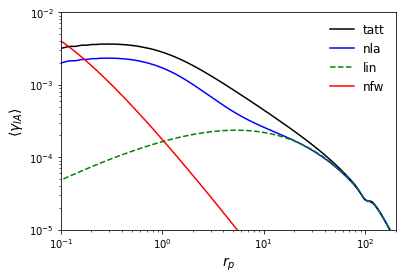

In [24]:
# Make a plot
plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(r,abs(gamma_avg_nla), 'b', label=r'nla')
plt.plot(r,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,2e2)
plt.ylim(1e-5,1e-2)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [ ]:
# Convert from r_p to theta for the redshift of the lenses: 0.3-0.45. Mean redshift used above is zz.
